# Boubakary Soumaré vs Amadou Onana - PCA Similarity Analysis
## Lille OSC - Pivote Defensivo

**Context:**
- Boubakary Soumaré: Pivote cantera Lille, vendido 20M€ (verano 2021)
- Amadou Onana: Fichado 13.5M€ para reemplazarlo, vendido 40M€ (verano 2022)
- Position: CDM (Defensive Midfielder)
- Analysis: PCA-based similarity algorithm to validate Onana as Soumaré replacement
- **Data analyzed: Soumaré 20/21 (1919 min), Onana 21/22 (1359 min)**

**Metodología:**
- **Pool PCA estandarizado**: CDM, 800+ min, max 32 años (SIN filtros económicos)
- **Big 5 leagues** - temporadas 20/21 y 21/22 combinadas
- **Ventaja**: PCA independiente de filtros económicos arbitrarios → evita cherry-picking
- **Filtros post-PCA**: Se aplican DESPUÉS para mostrar opciones viables (≤25M€, ≤25 años)

In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Subir tres niveles desde tfm/teams/lille/ hasta data/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from database.connection import get_db_manager
from tfm.helpers.query_helpers import query_player_pool, add_exogenous_player
from tfm.helpers.algorithms import find_similar_players_cosine

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pool PCA estandarizado (SIN filtros económicos)
# Big 5 leagues - temporadas 20/21 (2021) y 21/22 (2122) combinadas
# Posiciones: CDM (posición Transfermarkt)
big5_leagues = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
seasons = ['2021']  # 20/21 y 21/22

pools = []
for season in seasons:
    for league in big5_leagues:
        try:
            pool = query_player_pool(
                league=league,
                season=season,
                positions=['CDM'],  # Solo pivotes defensivos
                min_minutes=1000,
                max_age=30,
                table_type='domestic'
            )
            pools.append(pool)
            print(f"{league} {season}: {len(pool)} jugadores")
        except Exception as e:
            print(f"Error en {league} {season}: {e}")

pool_df = pd.concat(pools, ignore_index=True)

print(f"\nPool PCA (estandarizado): {len(pool_df)} jugadores")
print(f"\nDistribución por temporada:")
print(pool_df['season'].value_counts())
print(f"\nDistribución por liga:")
print(pool_df['league'].value_counts())

2026-01-18 10:15:36,731 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:36,937 - database.connection - INFO - Database connection successful
2026-01-18 10:15:37,017 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:37,048 - database.connection - INFO - Database connection successful
2026-01-18 10:15:37,089 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:37,123 - database.connection - INFO - Database connection successful
2026-01-18 10:15:37,157 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:37,195 - database.connection - INFO - Database connection successful


ENG-Premier League 2021: 30 jugadores
ESP-La Liga 2021: 16 jugadores
ITA-Serie A 2021: 23 jugadores


2026-01-18 10:15:37,232 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:37,267 - database.connection - INFO - Database connection successful


GER-Bundesliga 2021: 23 jugadores
FRA-Ligue 1 2021: 25 jugadores

Pool PCA (estandarizado): 117 jugadores

Distribución por temporada:
season
2021    117
Name: count, dtype: int64

Distribución por liga:
league
ENG-Premier League    30
FRA-Ligue 1           25
ITA-Serie A           23
GER-Bundesliga        23
ESP-La Liga           16
Name: count, dtype: int64


In [3]:
# Add Soumaré as exogenous player (target) - temporada 20/21
full_df = add_exogenous_player(
    pool_df=pool_df,
    player_name='Boubakary Soumaré',
    league='FRA-Ligue 1',
    season='2021',
    team='Lille',
    table_type='domestic'
)

print(f"DataFrame con Target: {len(full_df)} jugadores")

2026-01-18 10:15:37,351 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:37,388 - database.connection - INFO - Database connection successful


Added exogenous player: Boubakary Soumaré (Lille, FRA-Ligue 1 2021)
Total players in DataFrame: 118
DataFrame con Target: 118 jugadores


In [4]:
# Add Soumaré as exogenous player (target) - temporada 20/21
full_df = add_exogenous_player(
    pool_df=pool_df,
    player_name='Amadou Onana',
    league='FRA-Ligue 1',
    season='2122',
    team='Lille',
    table_type='domestic'
)

print(f"DataFrame con Target: {len(full_df)} jugadores")

2026-01-18 10:15:37,433 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 10:15:37,463 - database.connection - INFO - Database connection successful


Added exogenous player: Amadou Onana (Lille, FRA-Ligue 1 2122)
Total players in DataFrame: 118
DataFrame con Target: 118 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

fbref_nums = extract_metrics(full_df, 'fbref_metrics')
understat_nums = extract_metrics(full_df, 'understat_metrics')
transfermarkt_nums = extract_metrics(full_df, 'transfermarkt_metrics')

print(f"FBref: {fbref_nums.shape[1]} métricas")
print(f"Understat: {understat_nums.shape[1]} métricas")
print(f"Transfermarkt: {transfermarkt_nums.shape[1]} campos")

FBref: 185 métricas
Understat: 10 métricas
Transfermarkt: 2 campos


In [6]:
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches'
}

fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches FBref: {fbref_per100.shape[1]} columnas")
print(f"Per100touches Understat: {understat_per100.shape[1]} columnas")

Per100touches FBref: 183 columnas
Per100touches Understat: 10 columnas


In [7]:
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position', 'age']

df_final = pd.concat([
    full_df[base_cols],
    fbref_nums,
    understat_nums,
    transfermarkt_nums,
    fbref_per100,
    understat_per100
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} jugadores × {df_final.shape[1]} columnas")

DataFrame final: 118 jugadores × 397 columnas


In [8]:
# Identify target (Soumaré 20/21) and replacement (Onana 21/22)
target = df_final[
    (df_final['player_name'].str.contains('Soumar', case=False, na=False)) &
    (df_final['season'] == '2021')
]
replacement = df_final[
    (df_final['player_name'].str.contains('Amadou Onana', case=False, na=False)) &
    (df_final['season'] == '2122')
]

if len(target) == 0:
    raise ValueError("Target (Soumaré 20/21) no encontrado")
if len(replacement) == 0:
    raise ValueError("Replacement (Onana 21/22) no encontrado")

target_id = target.iloc[0]['unique_player_id']
replacement_id = replacement.iloc[0]['unique_player_id']

print(f"Target: {target.iloc[0]['player_name']} ({target.iloc[0]['team']}, {target.iloc[0]['season']})")
print(f"  ID: {target_id}")
print(f"\nReemplazo: {replacement.iloc[0]['player_name']} ({replacement.iloc[0]['team']}, {replacement.iloc[0]['season']})")
print(f"  ID: {replacement_id}")

Target: Boubakary Soumaré (Lille, 2021)
  ID: bfb5728f595635d0

Reemplazo: Amadou Onana (Lille, 2122)
  ID: 72810ae068cf92ba


In [9]:
# Run PCA similarity algorithm
result = find_similar_players_cosine(
    df=df_final,
    target_player_id=target_id,
    n_similar=30,
    pca_variance=0.85,
    replacement_id=replacement_id,
    robust_scaling=False,
    return_all_scores=True
)

Target: Boubakary Soumaré (Lille, FRA-Ligue 1)
Features: 170 (per 100 touches, excl. GK)
Jugadores: 118 (eliminados 0 con NaNs CORE)
PCA: 24 componentes (varianza: 85.1%)
Reducción: 170 → 24 dimensiones
Top-30 encontrados
Rango similitud: [0.3894, 0.8329]


In [10]:
# Filtrar resultados por restricciones de mercado (post-PCA)
# Contexto 2021: Onana fichado por 13.5M€, era joven (20 años)
MAX_VALUE = 25  # Millones €
MAX_AGE_FILTER = 25  # Edad máxima para filtrado económico

# Extraer datos del full_df
def get_market_value(player_id):
    player_row = full_df[full_df['unique_player_id'] == player_id]
    if len(player_row) == 0:
        return None
    tm_metrics = player_row.iloc[0].get('transfermarkt_metrics')
    if isinstance(tm_metrics, dict):
        val = tm_metrics.get('transfermarkt_market_value_eur')
        return float(val) / 1_000_000 if val else None
    return None

def get_age(player_id):
    player_row = full_df[full_df['unique_player_id'] == player_id]
    if len(player_row) == 0:
        return None
    return player_row.iloc[0].get('age')

# Obtener ALL scores (no solo top-30)
all_scores_df = result['all_scores'].copy()
all_scores_df['market_value_m'] = all_scores_df['unique_player_id'].apply(get_market_value)
all_scores_df['age'] = all_scores_df['unique_player_id'].apply(get_age)

# Filtrar TODO el pool por edad/valor de mercado
pool_filtrado_completo = all_scores_df[
    (all_scores_df['market_value_m'] <= MAX_VALUE) &
    (all_scores_df['age'] <= MAX_AGE_FILTER)
].copy()

# Re-rankear pool filtrado completo
pool_filtrado_completo = pool_filtrado_completo.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
pool_filtrado_completo['rank_filtrado'] = range(1, len(pool_filtrado_completo) + 1)

# Top-30 del pool completo (para display)
similar_df = result['similar_players'].copy()
similar_df['market_value_m'] = similar_df['unique_player_id'].apply(get_market_value)
similar_df['age'] = similar_df['unique_player_id'].apply(get_age)

print("TOP 30 - Pool Completo")
print("="*80)
print(similar_df[['rank', 'player_name', 'team', 'season', 'age', 'market_value_m', 'cosine_similarity']].head(30).to_string(index=False))

# Top-15 del pool filtrado (para display)
viable_df = pool_filtrado_completo.head(15).copy()

print(f"\n\nTOP 15 - Pool Filtrado (≤{MAX_VALUE}M€, ≤{MAX_AGE_FILTER} años)")
print("="*80)
print(f"Total jugadores en pool filtrado: {len(pool_filtrado_completo)}")
print("\n" + viable_df[['rank_filtrado', 'player_name', 'team', 'season', 'age', 'market_value_m', 'cosine_similarity']].head(15).to_string(index=False))

# REPLACEMENT VALIDATION
print("\n" + "="*80)
print("REPLACEMENT VALIDATION")
print("="*80)

replacement_name = replacement.iloc[0]['player_name'] if len(replacement) > 0 else "Replacement"

if replacement_id in pool_filtrado_completo['unique_player_id'].values:
    onana_row_filtered = pool_filtrado_completo[pool_filtrado_completo['unique_player_id'] == replacement_id].iloc[0]

    # Info del pool completo
    repl_info = result.get('replacement_info')
    rank_completo = repl_info['rank'] if repl_info else None

    print(f"✓ {replacement_name} encontrado en ambos pools")
    print(f"  Rank pool completo: {rank_completo}")
    print(f"  Rank pool filtrado: {onana_row_filtered['rank_filtrado']}/{len(pool_filtrado_completo)}")
    print(f"  Similitud: {onana_row_filtered['cosine_similarity']:.4f}")
    print(f"  Age: {onana_row_filtered['age']} | Market value: {onana_row_filtered['market_value_m']:.1f}M€")
    print(f"\n  Status: VALIDADO" if onana_row_filtered['rank_filtrado'] <= 10 else f"  Status: Rank {onana_row_filtered['rank_filtrado']}")
else:
    repl_info = result.get('replacement_info')
    if repl_info and repl_info.get('rank'):
        rank_completo = repl_info['rank']
        age = get_age(replacement_id)
        market_value = get_market_value(replacement_id)

        print(f"✓ {replacement_name} en pool completo, NO en pool filtrado")
        print(f"  Rank pool completo: {rank_completo}")
        print(f"  Age: {age} | Market value: {market_value:.1f}M€" if market_value else f"  Age: {age}")

        reasons = []
        if market_value and market_value > MAX_VALUE:
            reasons.append(f"valor {market_value:.1f}M€ > {MAX_VALUE}M€")
        if age and age > MAX_AGE_FILTER:
            reasons.append(f"edad {age} > {MAX_AGE_FILTER}")
        print(f"  Excluido: {', '.join(reasons)}")
    else:
        print(f"✗ {replacement_name} NO encontrado en pool PCA")

TOP 30 - Pool Completo
 rank         player_name            team season  age  market_value_m  cosine_similarity
    1        Granit Xhaka         Arsenal   2021   27            22.0           0.832906
    2               Rodri Manchester City   2021   24            70.0           0.807916
    3       Thomas Partey         Arsenal   2021   27            40.0           0.760410
    4     Leandro Paredes       Paris S-G   2021   26            20.0           0.749743
    5       Thiago Mendes            Lyon   2021   28            15.0           0.704651
    6      Mohamed Elneny         Arsenal   2021   28            10.0           0.696202
    7    Martín Zubimendi   Real Sociedad   2021   21            20.0           0.690050
    8 Morgan Schneiderlin            Nice   2021   30             7.0           0.685141
    9    Jordan Henderson       Liverpool   2021   30            20.0           0.677106
   10             Fabinho       Liverpool   2021   26            60.0           0.67307

Visualización: /home/jaime/FD/data/tfm/teams/lille/soumare_onana_top10_ranking.png


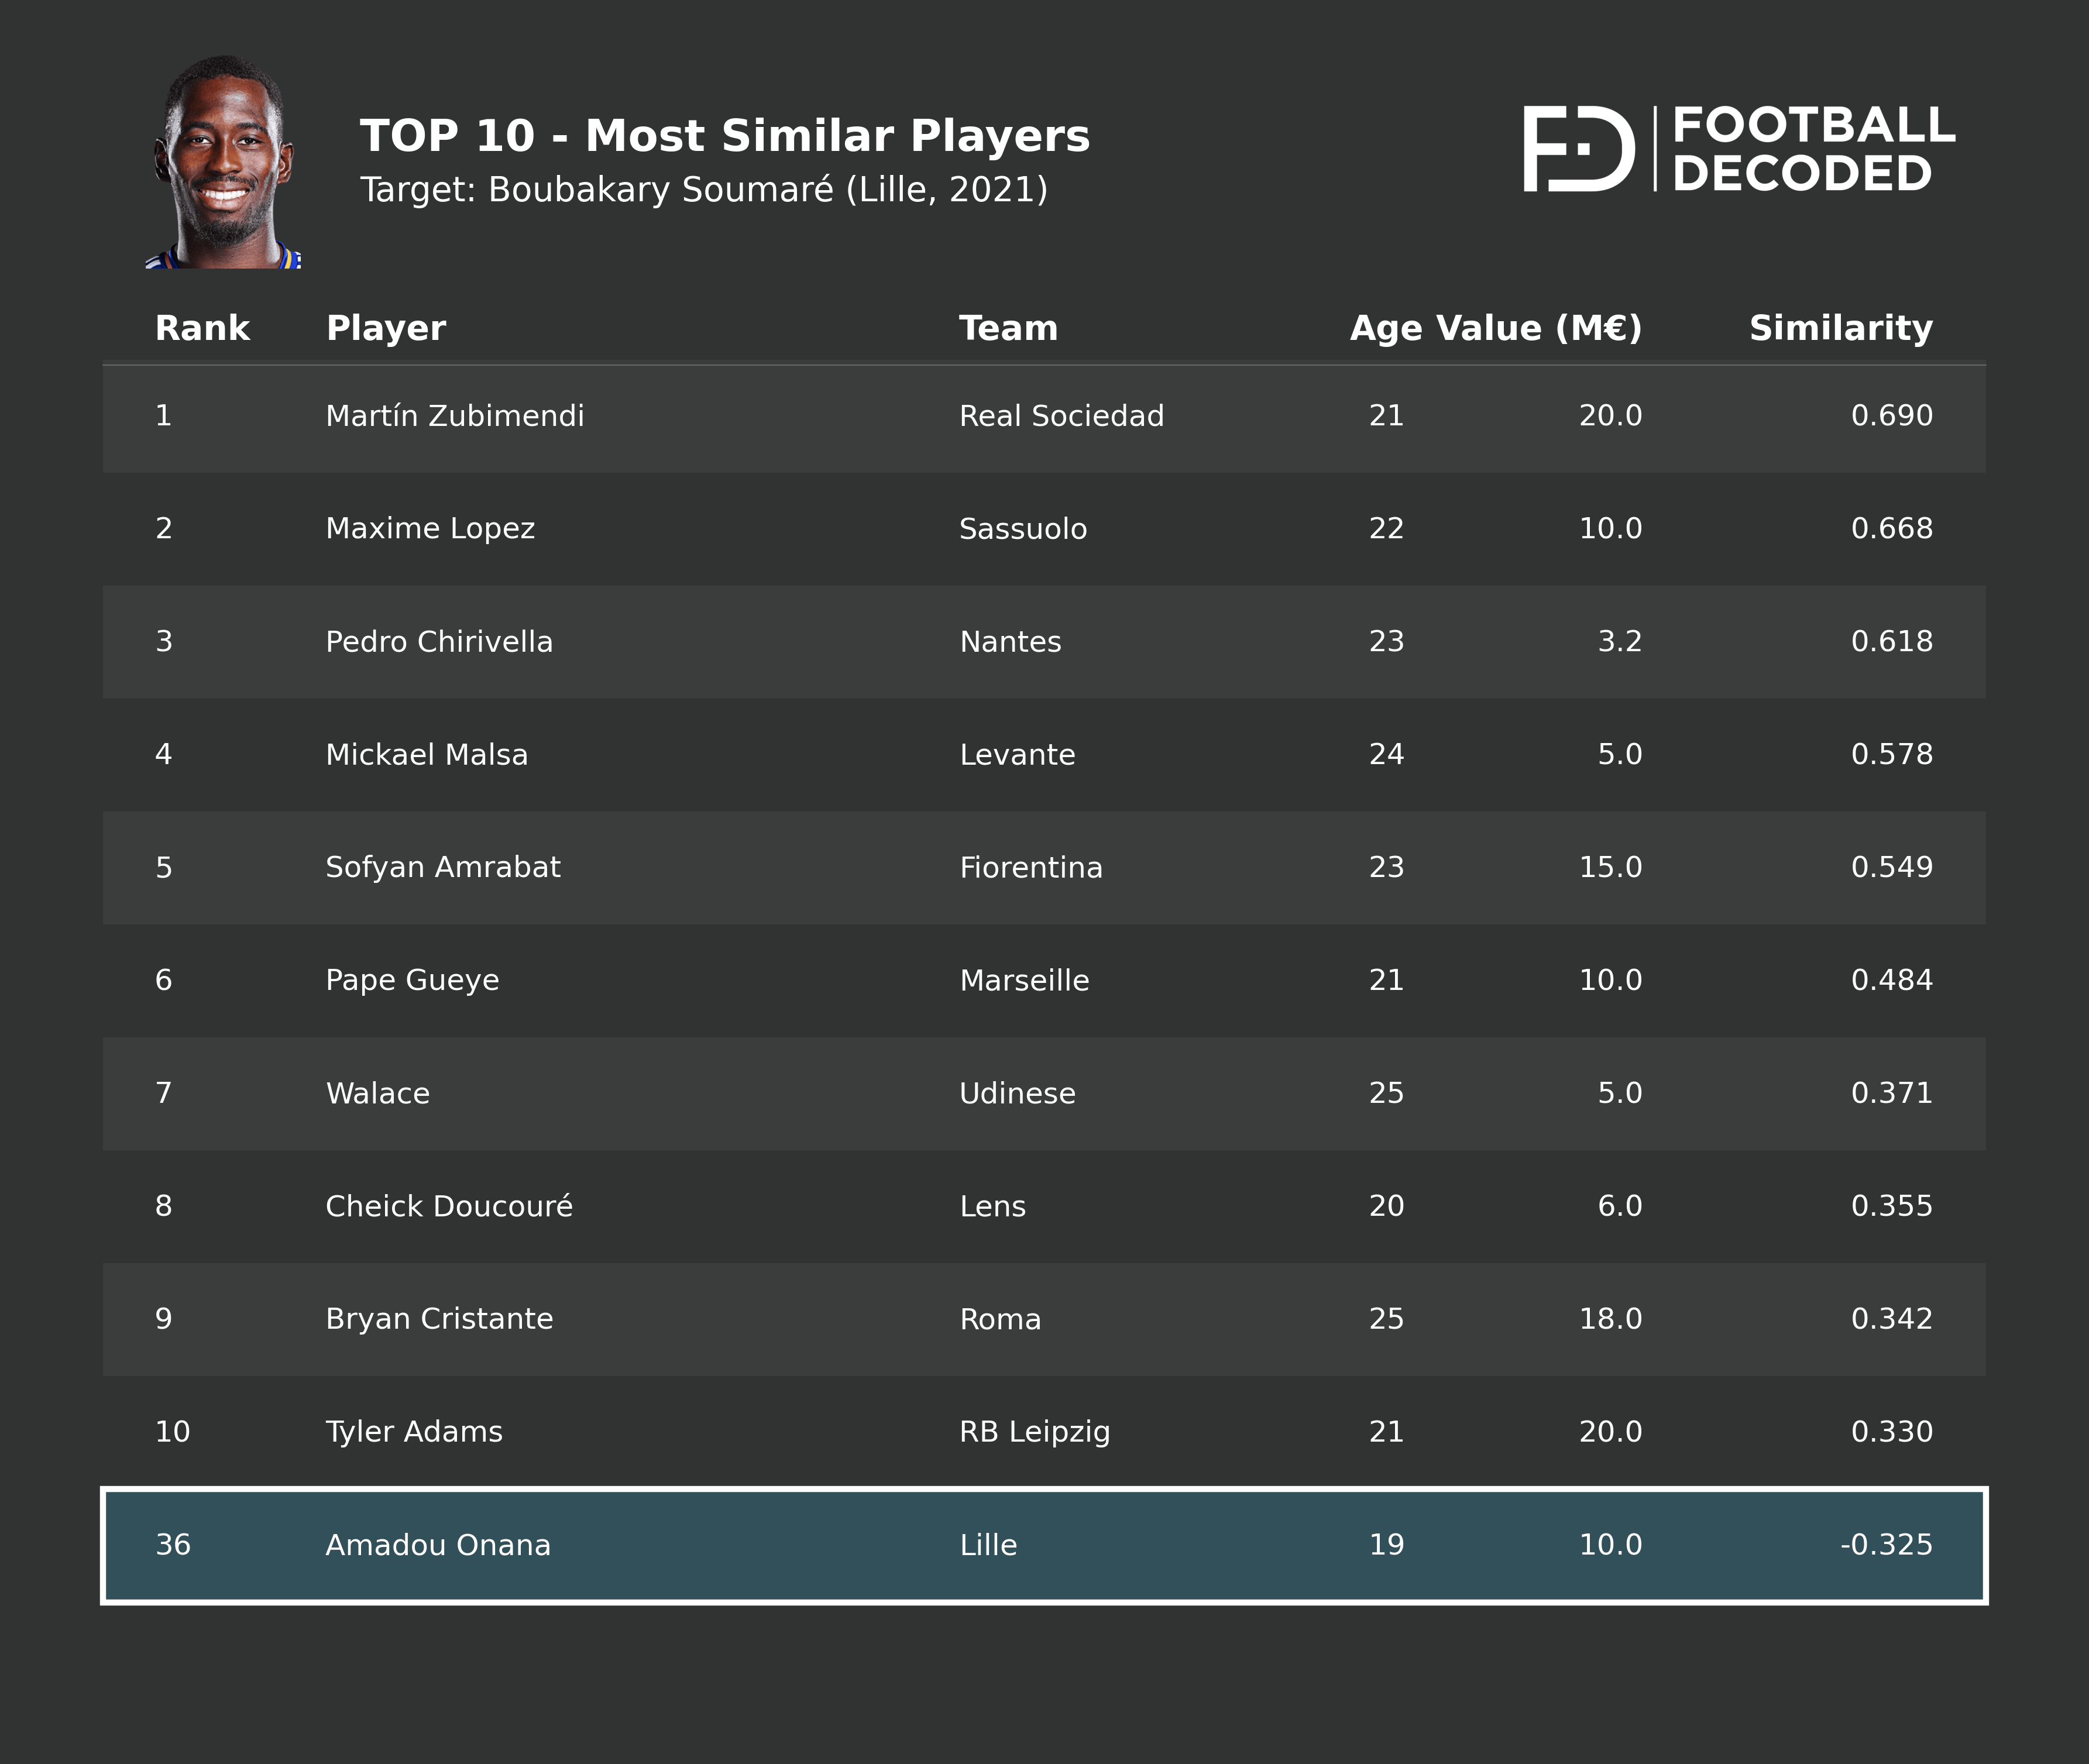

In [11]:
from tfm.helpers.viz_helpers import plot_top10_ranking

# Preparar pool filtrado completo para viz
pool_viz = pool_filtrado_completo.copy()

# Eliminar rank original del PCA (viene de all_scores)
if 'rank' in pool_viz.columns:
    pool_viz = pool_viz.drop(columns=['rank'])

# Renombrar rank_filtrado a rank para que la viz lo use
pool_viz = pool_viz.rename(columns={'rank_filtrado': 'rank'})

# Quitar age/market_value para que plot_top10_ranking los añada
pool_viz = pool_viz.drop(columns=['age', 'market_value_m'])

# Preparar result para viz
result_viable = result.copy()
result_viable['similar_players'] = pool_viz

# Override replacement_info con rank filtrado
if replacement_id in pool_filtrado_completo['unique_player_id'].values:
    onana_row = pool_filtrado_completo[pool_filtrado_completo['unique_player_id'] == replacement_id].iloc[0]
    result_viable['replacement_info'] = {
        'player_name': onana_row['player_name'],
        'unique_player_id': replacement_id,
        'team': onana_row['team'],
        'league': onana_row['league'],
        'season': onana_row['season'],
        'rank': int(onana_row['rank_filtrado']),
        'cosine_similarity': float(onana_row['cosine_similarity'])
    }

output_path = plot_top10_ranking(
    result=result_viable,
    df_data=full_df,
    save_path='soumare_onana_top10_ranking.png',
    target_face_path='/home/jaime/FD/data/blog/caras/tfm/soumare.png',
    highlight_target=True,
    dpi=300
)

print(f"Visualización: {output_path}")

from IPython.display import Image, display
display(Image(filename=output_path))

In [12]:
# PCA Information
pca_info = result['pca_info']

print("\nINFORMACIÓN PCA")
print("="*80)
print(f"Dimensiones originales: {pca_info['original_dimensions']}")
print(f"Componentes retenidos: {pca_info['n_components']}")
print(f"Varianza explicada: {pca_info['explained_variance_ratio']:.1%}")
print(f"Ratio de compresión: {pca_info['compression_ratio']:.1%}")
print("\nVarianza por componente (top-5):")
for i, var in enumerate(pca_info['top_5_components_variance'], 1):
    print(f"  PC{i}: {var:.1%}")


INFORMACIÓN PCA
Dimensiones originales: 170
Componentes retenidos: 24
Varianza explicada: 85.1%
Ratio de compresión: 14.1%

Varianza por componente (top-5):
  PC1: 17.3%
  PC2: 15.3%
  PC3: 8.9%
  PC4: 5.6%
  PC5: 5.4%


In [13]:
# Similarity Score Distribution
dist = result['score_distribution']

print("\nDISTRIBUCIÓN DE SIMILITUDES")
print("="*80)
print(f"Mínimo:   {dist['min']:.4f}")
print(f"Q5:       {dist['q5']:.4f}")
print(f"Q25:      {dist['q25']:.4f}")
print(f"Mediana:  {dist['median']:.4f}")
print(f"Q75:      {dist['q75']:.4f}")
print(f"Q95:      {dist['q95']:.4f}")
print(f"Máximo:   {dist['max']:.4f}")
print(f"Media:    {dist['mean']:.4f}")
print(f"Desv.Est: {dist['std']:.4f}")


DISTRIBUCIÓN DE SIMILITUDES
Mínimo:   -0.7515
Q5:       -0.5098
Q25:      -0.2670
Mediana:  0.0388
Q75:      0.3894
Q95:      0.6913
Máximo:   0.8329
Media:    0.0642
Desv.Est: 0.3979
